# 📈 Analysis of Indian Stock Market: Jan 2017 - Jan 2021

This notebook looks into indian stock market trends during the period of `January, 2017` to  `January, 2021`. 

- Notes on [Spark2 with Python notebook](https://datascienceplus.com/leveraging-hive-with-spark-using-python/).

## Table of Contents

- [Analysis of Indian Stock Market: Jan 2017 - Jan 2021](#📈-Analysis-of-Indian-Stock-Market:-Jan-2017---Jan-2021)
  - [Table of Contents](#table-of-contents)
  - [Installing / Getting started](#installing--getting-started)
    - [Configure](#configure)
    - [Initialize](#initialize)
    - [Optional: Workspaces](#optional-workspaces)
    - [Provisioning](#provisioning)
  - [Basic commands](#basic-commands)
    - [Docker troubleshooting](#docker-troubleshooting)
      - [Sandbox Bash](#sandbox-bash)
    - [Setup Python](#setup-python)
      - [If python 3.6 needed](#if-python-36-needed)
  - [References](#references)
  - [License](#license)

## Problem Definition

## Data

The data is downloaded from kaggle [Indian Stock Market (NSE)](https://www.kaggle.com/hk7797/stock-market-india).
The data is licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).

There are 4 main datasets:
- `FullDataCSV` - this contains `~3.38gb`
- `FullData.h5` - this `~2.66gb`
- `master.csv` - this contains the 

## Evaluation

## Features

## Preparing the tools

We're will be using `pandas`, `matplotlib`, `spark2` and `numpy` for data analysis and manipulation.

**NOTE:** Most of the proceeding pyspark code works with `spark2-client` hence make sure your path is set appropriately.

In [4]:
# making sure that we're using spark2-client
!echo $PYTHONPATH

/usr/hdp/current/spark2-client/python:/usr/hdp/current/spark2-client/python/lib/py4j-0.10.6-src.zip


In [99]:
# import all the required libraries

# regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# import interactive graphs
import plotly.graph_objects as go
import plotly.express as px

# we want out plots to appear inside the notebook
%matplotlib inline

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.enableHiveSupport().getOrCreate()

## Load Data

Load the hive database `stocks_db` to spark

In [7]:
spark.sql('show databases')
spark.sql('use stocks_db')
spark.sql('show tables').toPandas()

,database,tableName,isTemporary
0,stocks_db,stocks,False


## Data Exploration (exploratory data analysis or EDA)

Exploring the dataset we're working with

#### Information about the Database

#### Types of Column in the Data

In [8]:
abt_db = spark.sql("describe formatted stocks").toPandas()
abt_db.iloc[0:9, 0:2]

,col_name,data_type
0,exch,string
1,symbol,string
2,ymd,timestamp
3,price_open,float
4,price_high,float
5,price_low,float
6,price_close,float
7,volume,int
8,price_adj_close,float


In [9]:
abt_db.iloc[11:17, 0:2]

,col_name,data_type
11,Database,stocks_db
12,Table,stocks
13,Owner,maria_dev
14,Created Time,Sat Jul 10 20:03:38 UTC 2021
15,Last Access,Thu Jan 01 00:00:00 UTC 1970
16,Created By,Spark 2.2 or prior


#### Number of Stocks Symbols in the Dataset

In [10]:
distinct_count = spark.sql("SELECT COUNT (*) AS count FROM (SELECT DISTINCT symbol FROM stocks)").toPandas()
distinct_count['count'][0]

159

#### Total Number of Records in the Processed Dataset

In [11]:
total_record_count = spark.sql("SELECT COUNT (*) AS count FROM stocks").toPandas()
total_record_count['count'][0]

152426

#### Record Breakdown Based on Stocks

In [12]:
spark.sql("SELECT symbol, count(*) AS count FROM stocks\
          GROUP BY symbol\
          HAVING count(*) > 100 \
          ORDER BY count DESC").toPandas()

,symbol,count
0,LT,992
1,ICICIBANK,992
2,L&TFH,992
3,IDEA,992
4,TITAN,992
...,...,...
154,NIFTY COMMODITIES,510
155,DALBHARAT,483
156,POLYCAB,425
157,NIFTY 500,375


## Analysis

### 1. Analysing and comparing all companies share market

### 1.1 Annual turnover (`total_volume` * `close`)

#### Total Turnover from Jan 2017 - Jan 2021

In [13]:
sparkdf = spark.sql("SELECT exch, ceil(SUM(price_close*volume)) AS total_turn_over, symbol FROM stocks \
GROUP BY exch, symbol \
ORDER BY total_turn_over DESC").toPandas()
sparkdf

,exch,total_turn_over,symbol
0,NSE,416452745334,RELIANCE
1,NSE,322030594578,TCS
2,NSE,304482216548,HINDUNILVR
3,NSE,297107644991,HDFC
4,NSE,287979041595,KOTAKBANK
...,...,...,...
154,NSE,0,NIFTY 50
155,NSE,0,NIFTY ENERGY
156,NSE,0,NIFTY MIDCAP 100
157,NSE,0,NIFTY 500


In [14]:
# Create a function to generate barplot
def show_barplot(df, x, y, xlabel, ylabel, title, rotate=0, figsize=(10,5)):
    """
    Display bar graph
    """
    with sns.axes_style('white'):
        df.plot(kind="bar", x=x, y=y, figsize=figsize)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=rotate)

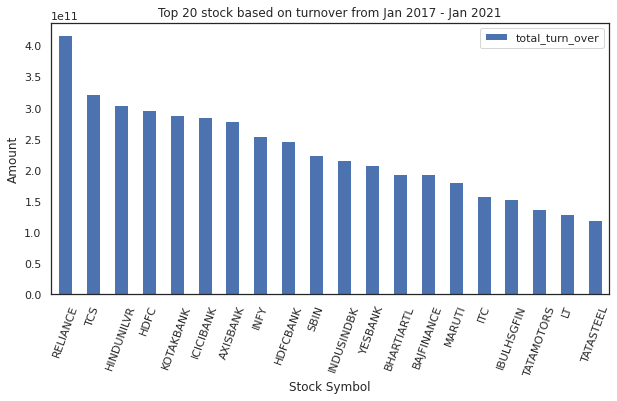

In [15]:
show_barplot(
    sparkdf.head(20), 
    x="symbol", 
    y="total_turn_over", 
    xlabel="Stock Symbol", 
    ylabel="Amount", 
    title= "Top 20 stock based on turnover from Jan 2017 - Jan 2021",
    rotate=70
)

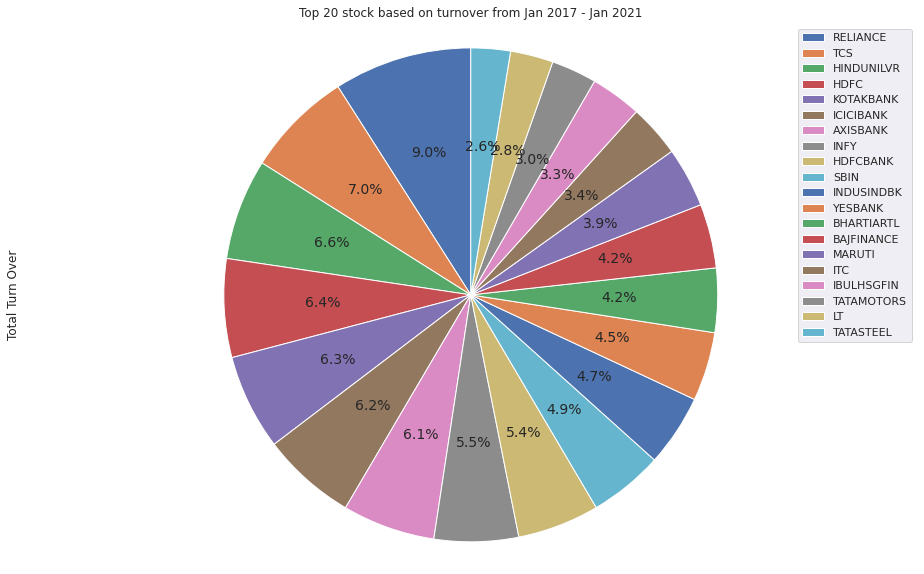

In [16]:
df = sparkdf.head(20)
df.plot(kind='pie', y = 'total_turn_over', autopct='%1.1f%%', 
 startangle=90, shadow=False, fontsize=14, labeldistance=None, figsize=(16,10))
plt.title('Top 20 stock based on turnover from Jan 2017 - Jan 2021')
plt.legend(labels=df["symbol"], loc='best', prop={'size': 11})
plt.ylabel("Total Turn Over")
plt.axis('equal')
plt.show()

#### Specific Annual Turnover

In [17]:
df

,exch,total_turn_over,symbol
0,NSE,416452745334,RELIANCE
1,NSE,322030594578,TCS
2,NSE,304482216548,HINDUNILVR
3,NSE,297107644991,HDFC
4,NSE,287979041595,KOTAKBANK
5,NSE,285258845228,ICICIBANK
6,NSE,279597586598,AXISBANK
7,NSE,254110216872,INFY
8,NSE,247001134982,HDFCBANK
9,NSE,223955827268,SBIN


#### Validating if the `total_turnover` sum is accurate

In [18]:
years = [2017,  2018, 2019, 2020, 2021]
sum = 0
for y in years:
    sparkdf = spark.sql("SELECT exch,ceil(SUM(price_close*volume)) AS total_turn_over, symbol, year(ymd) AS Year FROM stocks \
    WHERE year(ymd)={year} AND symbol='HINDUNILVR' \
    GROUP BY exch, year(ymd),symbol \
    ORDER BY Year DESC, total_turn_over DESC".format(year=y)).toPandas()
    print(y, int(sparkdf.head(1)["total_turn_over"]))
    sum += int(sparkdf.head(1)["total_turn_over"])
    
print("The total turnover is", sum)

2017 22244699101
2018 21234122675
2019 30741271822
2020 230199167846
2021 62955104
The total turnover is 304482216548


#### Lowest Total Turnover  from Jan 2017 - Jan 2021

In [97]:
sparkdf = spark.sql("SELECT exch, ceil(SUM(price_close*volume)) AS total_turn_over, symbol FROM stocks \
GROUP BY exch, symbol \
ORDER BY total_turn_over ASC \
LIMIT 20").toPandas()
sparkdf

,exch,total_turn_over,symbol
0,NSE,0,NIFTY 500
1,NSE,0,NIFTY ENERGY
2,NSE,0,NIFTY AUTO
3,NSE,0,NIFTY 50
4,NSE,0,NIFTY 100
5,NSE,0,NIFTY COMMODITIES
6,NSE,0,NIFTY MIDCAP 100
7,NSE,0,NIFTY FIN SERVICE
8,NSE,0,NIFTY BANK
9,NSE,8311035080,GODREJAGRO


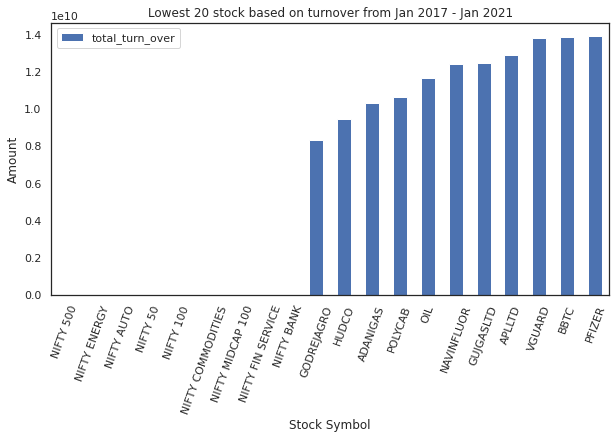

In [105]:
show_barplot(
    sparkdf.head(20), 
    x="symbol", 
    y="total_turn_over", 
    xlabel="Stock Symbol", 
    ylabel="Amount", 
    title= "Lowest 20 stock based on turnover from Jan 2017 - Jan 2021",
    rotate=70,
    figsize=(10,5)
)

### 1.2 Annual average open vs average annual close

In [49]:
sparkdf = spark.sql("SELECT exch, symbol, count(symbol), ceil(AVG(price_close)) AS average_close, \
ceil(AVG(price_open)) AS average_open,  year(ymd) AS Year \
FROM stocks \
GROUP BY exch, symbol, year(ymd) \
ORDER BY Year DESC, average_close DESC").toPandas()
sparkdf

,exch,symbol,count(symbol),average_close,average_open,Year
0,NSE,MRF,1,76200,76200,2021
1,NSE,NIFTY BANK,1,31379,31381,2021
2,NSE,PAGEIND,1,28257,28237,2021
3,NSE,SHREECEM,1,24247,24247,2021
4,NSE,NIFTY MIDCAP 100,1,21122,21122,2021
...,...,...,...,...,...,...
778,NSE,NATIONALUM,248,76,76,2017
779,NSE,JSWENERGY,248,71,71,2017
780,NSE,SAIL,248,66,66,2017
781,NSE,IDFCFIRSTB,248,60,60,2017


In [29]:
# visualize the annual open and close for year
ann_close_open_year = 2020

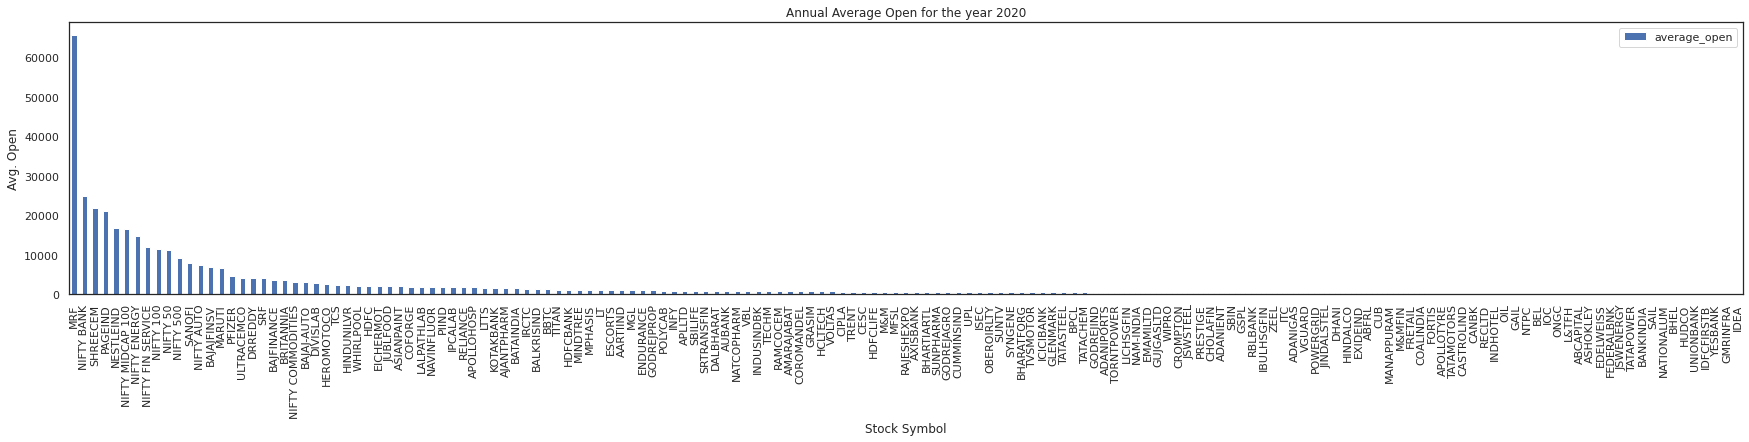

In [30]:
show_barplot(
    sparkdf[sparkdf["Year"] == ann_close_open_year], 
    figsize=(30,5),
    x="symbol", 
    y="average_open", 
    xlabel="Stock Symbol", 
    ylabel="Avg. Open", 
    title= "Annual Average Open for the year {year}".format(year=ann_close_open_year),
    rotate=90
)

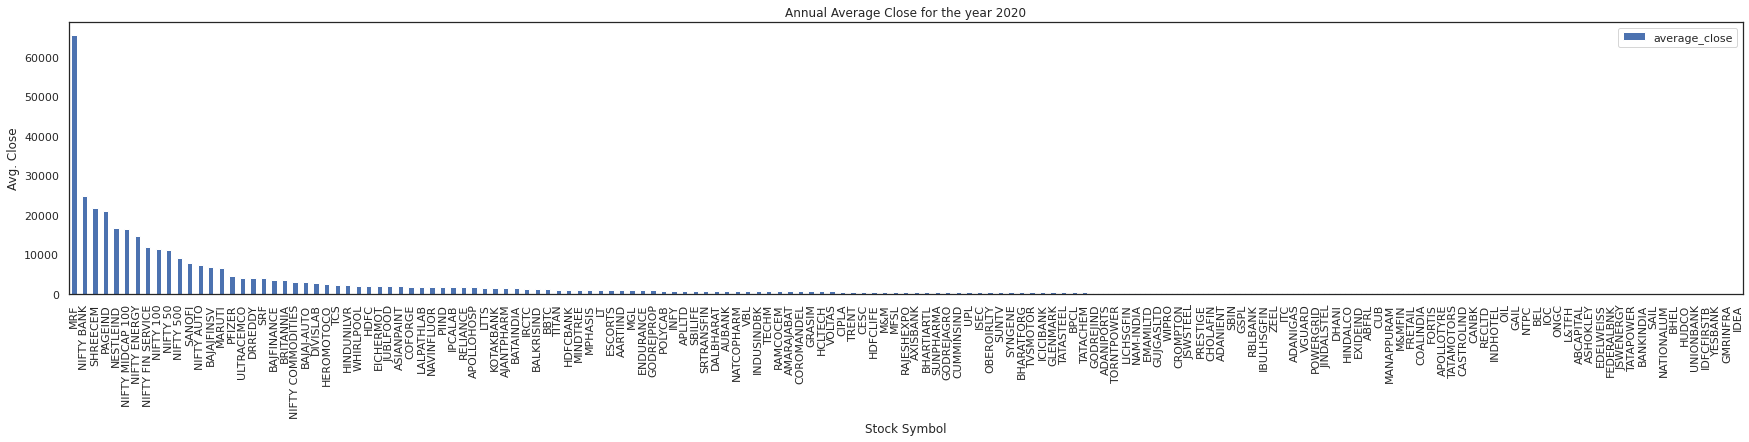

In [31]:
show_barplot(
    sparkdf[sparkdf["Year"] == ann_close_open_year], 
    figsize=(30,5),
    x="symbol", 
    y="average_close", 
    xlabel="Stock Symbol", 
    ylabel="Avg. Close", 
    title= "Annual Average Close for the year {year}".format(year=ann_close_open_year),
    rotate=90
)

## 2. Analysing 10 top turnovers during covid-19 and before covid-19 annually

In [32]:
def top_10_turnovers_by_year(year):
    return spark.sql("SELECT exch, ceil(SUM(price_close*volume)) AS total_turn_over, symbol, year(ymd) AS Year \
    FROM stocks \
    WHERE year(ymd)={year} \
    GROUP BY exch, year(ymd), symbol \
    ORDER BY Year DESC, total_turn_over DESC \
    LIMIT 10".format(year=year)).toPandas()

### 2.1 Year of 2020

In [45]:
sparkdf = top_10_turnovers_by_year(2020)
sparkdf

,exch,total_turn_over,symbol,Year
0,NSE,230199167846,HINDUNILVR,2020
1,NSE,190434379264,RELIANCE,2020
2,NSE,130137395916,HDFCBANK,2020
3,NSE,104579971424,BAJFINANCE,2020
4,NSE,95163072096,HDFC,2020
5,NSE,89562452880,ICICIBANK,2020
6,NSE,88527615056,BHARTIARTL,2020
7,NSE,77939572564,TCS,2020
8,NSE,76426666744,SBIN,2020
9,NSE,73043319552,INDUSINDBK,2020


#### Stocks Turnover for Single Year 2020

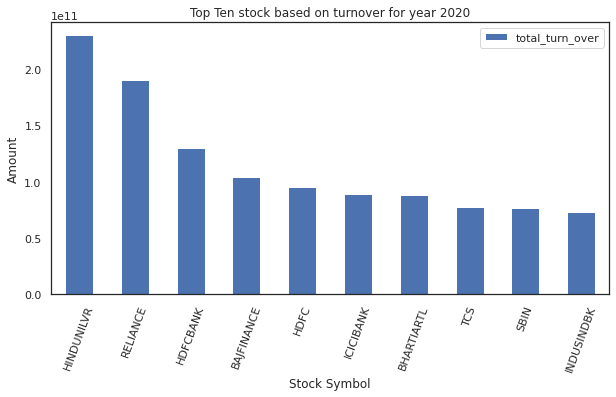

In [46]:
year = 2020
show_barplot(
    sparkdf, 
    x="symbol", 
    y="total_turn_over", 
    xlabel="Stock Symbol", 
    ylabel="Amount", 
    title= "Top Ten stock based on turnover for year 2020".format(year=year),
    rotate=70
)

#### Stocks Turnover Before and After Covid 

In [47]:
# Create a function for viewing plots as a batch
def show_5_plots(dfs, labels):
    """
    Display 4 plots from a data batch
    """
    with sns.axes_style('white'):
        # Setup the figure
        plt.figure(figsize=(20,15))
        # Loop through the 5 images
        for i in range(5):
            # Create subplots (3 rows, 2 columns)
            ax = plt.subplot(3, 2, i+1)
            # Display plot
            tp_plt = plt.bar(dfs[i]["symbol"], dfs[i]["total_turn_over"], color=["grey"])
            plt.title(labels[i])
            plt.xlabel("Stock Symbol")
            plt.ylabel("Amount")
            plt.xticks(rotation=70)
            tp_plt[0].set_color("lightgreen")
        # add padding
        plt.tight_layout(h_pad=1.0)

In [48]:
dfs = list()
labels = list()
years = [2017, 2018, 2019, 2020, 2021]

for year in years:
    # append all the data by year
    dfs.append(top_10_turnovers_by_year(year))
    # add title
    labels.append("Top ten turnover for year {year}".format(year=year))

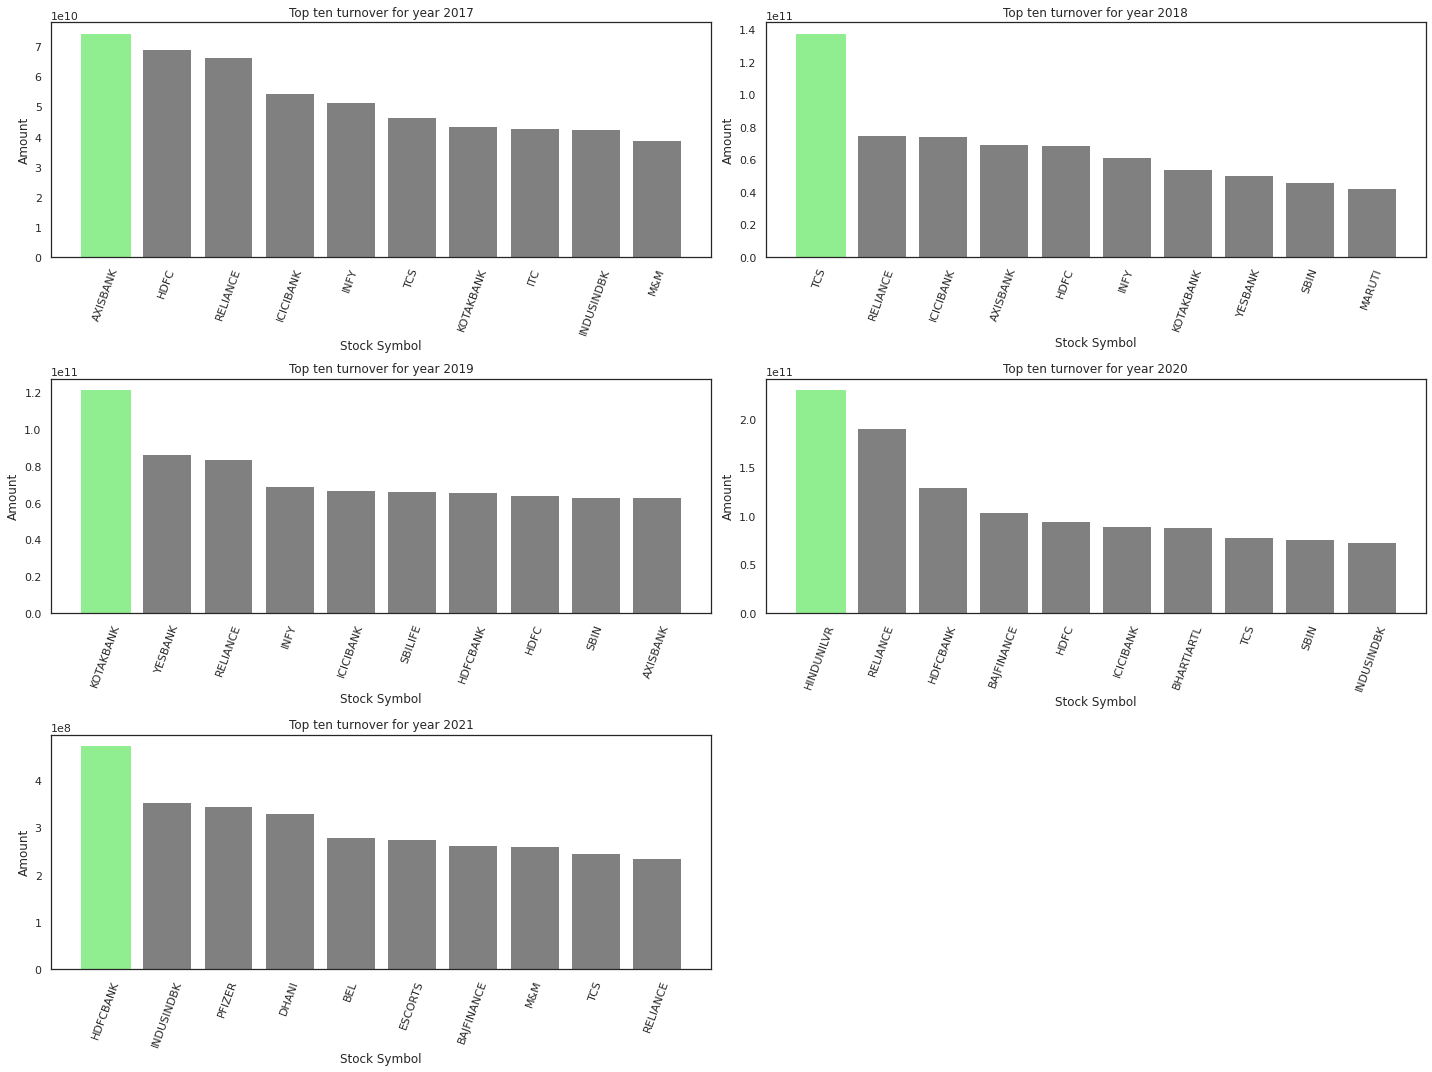

In [44]:
show_5_plots(dfs, labels)

### 3. Analaysing worst affected companies due to Covid-19 that means it was profitable before that.
Chart is needed.


#### `PFIZER` rise

In [91]:
# Create a function for viewing the trends of stocks
def show_tt_trend(symbol):
    """
    Display trends of stocks
    """
    
    # get the list of total turnover by each year
    sparkdf = spark.sql("SELECT exch,ceil(SUM(price_close*volume)) AS total_turn_over, symbol, year(ymd) AS year FROM stocks \
    WHERE symbol='{sym}' \
    GROUP BY exch, year(ymd),symbol \
    ORDER BY year ASC, total_turn_over DESC".format(sym=symbol)).toPandas()
        
    df = sparkdf[['year', 'total_turn_over']]

    fig = px.line(df, x='year', y='total_turn_over')
    fig.update_xaxes(nticks=int(df.count()["year"]))
    fig.update_yaxes(
            title_text = "Total Turnover",
            title_standoff = 25)
    fig.update_layout(
    title={
        'text': "{sym} stock trend 2017 - 2021".format(sym=symbol),
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

    fig.update_xaxes(
            title_text = "Year",
            title_standoff = 25)
    fig.show()

####  Trend `PFIZER`

In [96]:
show_tt_trend("PFIZER")

####  Trend `HDFC`

In [93]:
show_tt_trend("HDFC")

####  Trend `DHANI`

In [94]:
show_tt_trend("DHANI")

####  Trend `BAJFINANCE`

In [95]:
show_tt_trend("BAJFINANCE")

#### ⚠️ Example `Monthly` trends

In [37]:
sparkdf = spark.sql("SELECT exch,ceil(SUM(price_close*volume)) AS turn_over, symbol, ymd AS Date FROM stocks \
WHERE symbol='PFIZER' \
GROUP BY exch, ymd, symbol \
ORDER BY Date ASC, turn_over DESC").toPandas()
sparkdf

,exch,turn_over,symbol,Date
0,NSE,863040,PFIZER,2017-01-02
1,NSE,801895,PFIZER,2017-01-03
2,NSE,488819,PFIZER,2017-01-04
3,NSE,953680,PFIZER,2017-01-05
4,NSE,2802740,PFIZER,2017-01-06
...,...,...,...,...
987,NSE,9341941,PFIZER,2020-12-28
988,NSE,14877285,PFIZER,2020-12-29
989,NSE,7439164,PFIZER,2020-12-30
990,NSE,5153444,PFIZER,2020-12-31


In [40]:
import plotly.graph_objects as go
import plotly.express as px

df = sparkdf

fig = px.line(df, x='Date', y='turn_over', title="PFIZER stock trend 2017 - 2021")
fig.update_xaxes(nticks=49)
fig.update_yaxes(
        title_text = "Total Turnover",
        title_standoff = 25)

fig.update_xaxes(
        title_text = "Date",
        title_standoff = 25)
fig.show()
